# Guide to arcgis.geometry module (Part 3)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-Case" data-toc-modified-id="Use-Case-1">Use Case</a></span></li><li><span><a href="#Import-and-Data-Preparation" data-toc-modified-id="Import-and-Data-Preparation-2">Import and Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Input-Data-(Freeway)" data-toc-modified-id="Input-Data-(Freeway)-2.1">Input Data (Freeway)</a></span></li><li><span><a href="#Input-Data-(Fire)" data-toc-modified-id="Input-Data-(Fire)-2.2">Input Data (Fire)</a></span></li><li><span><a href="#Input-Data-(Wilderness-Preservation-Area)" data-toc-modified-id="Input-Data-(Wilderness-Preservation-Area)-2.3">Input Data (Wilderness Preservation Area)</a></span></li><li><span><a href="#State-and-County-Boundaries-from-Geoenrichment" data-toc-modified-id="State-and-County-Boundaries-from-Geoenrichment-2.4">State and County Boundaries from Geoenrichment</a></span></li></ul></li><li><span><a href="#arcgis.geometry.filters-module" data-toc-modified-id="arcgis.geometry.filters-module-3"><code>arcgis.geometry.filters</code> module</a></span><ul class="toc-item"><li><span><a href="#intersects" data-toc-modified-id="intersects-3.1">intersects</a></span></li></ul></li><li><span><a href="#contains-V.S.-within" data-toc-modified-id="contains-V.S.-within-4">contains V.S. within</a></span><ul class="toc-item"><li><span><a href="#Crosses-V.S.-Overlaps" data-toc-modified-id="Crosses-V.S.-Overlaps-4.1">Crosses V.S. Overlaps</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-filtered-results" data-toc-modified-id="Visualizing-the-filtered-results-4.1.1">Visualizing the filtered results</a></span></li><li><span><a href="#Consider-the-impacted-roads" data-toc-modified-id="Consider-the-impacted-roads-4.1.2">Consider the impacted roads</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5">Conclusions</a></span></li></ul></div>

Previously, in <a href="./guide_to_geometry_part2.ipynb">Part 2</a> of this guide series to `arcgis.geometry` module, you have been introduced to two ways of conducting spatial operations such as `union` and `intersection`, with `ArcGIS API for Python` - the OOP style, and/or the global functions. Now in Part 3 let us continue to explore how the spatial filtering can be applied within the `arcgis.geometry.filters` sub-module, which include functions to filter query results by a spatial relationship with another geometry used when querying feature layers and imagery layers. The spatial filtering is even more powerful, when integrated with `geoenrichment`.


## Use Case

For example, Jim is a Highway Engineer working for the Department of Transportation, and he is performing some facts checking with interstate highways in California. Let's see how he takes advantage of the `arcgis.geometry.filters` in asnwering these questions:
  - Among all Interstate Highways in the United States, which ones go through the San Bernadino County of California, and which ones go through the Los Angeles County.
  - Are there any highways that are wholly contained inside the San Bernadino County? Are there any ones that only run inside the LA County?
  - Check if any of the Interstate Highways are too close to the wilderness protected areas in San Bernadino County.
  - In case of wildfires, are the wilderness protected areas in a safe distance from the incidents? and which Interstate Highways are too close to the areas impacted by wildfires?
  
  
## Import and Data Preparation

First of all, let us import the necessary libraries, and then create a GIS connection object to the ArcGIS online organization.

In [1]:
from arcgis.gis import GIS
from arcgis.geometry import Geometry, Polyline, Point, union
from arcgis.geometry.filters import *
from arcgis.geoenrichment import *
from arcgis.features import FeatureLayer

In [2]:
gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123", verify_cert=False)

### Input Data (Freeway)

<Item title:"USA Freeway System" type:Feature Layer Collection owner:esri_dm>
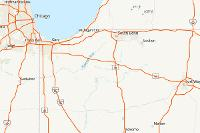

In [3]:
freeway_item = gis.content.search("USA Freeway System AND type:Feature Layer", outside_org=True)[0]
freeway_item

In [4]:
freeway_lyr = freeway_item.layers[0]
freeway_lyr

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Freeway_System/FeatureServer/1">

### Input Data (Fire)

<Item title:"USA Current Wildfires" type:Feature Layer Collection owner:esri_livefeeds2>
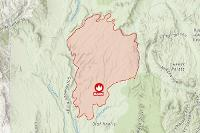

In [5]:
wildfire_item = gis.content.search("USA Current Wildfires AND type:Feature Layer", outside_org=True)[0]
wildfire_item

In [6]:
wildfire_lyr = wildfire_item.layers[0]
wildfire_lyr

<FeatureLayer url:"https://services9.arcgis.com/RHVPKKiFTONKtxq3/arcgis/rest/services/USA_Wildfires_v1/FeatureServer/0">

### Input Data (Wilderness Preservation Area)

<Item title:"Wilderness Areas in the United States" type:Feature Layer Collection owner:wildernesswebmaster99>
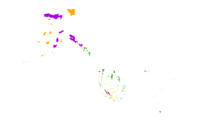

In [7]:
# "Wilderness Areas in the United States"
wild_areas_item = gis.content.search("Wilderness Areas in the United States AND owner:wildernesswebmaster99",
                                     item_type="Feature Layer",
                                     outside_org=True)[0]
wild_areas_item

In [8]:
wild_areas_lyr = wild_areas_item.layers[0]
wild_areas_lyr

<FeatureLayer url:"https://services1.arcgis.com/ERdCHt0sNM6dENSD/arcgis/rest/services/Wilderness_Areas_in_the_United_States/FeatureServer/1">

### State and County Boundaries from Geoenrichment

`GeoEnrichment` provides the ability to get facts about a location or area. Using GeoEnrichment, you can get information about the people, places, and businesses in a specific area or within a certain distance or drive time from a location. It enables you to query and use information from a large collection of data sets including population, income, housing, consumer behavior, and the natural environment.

Next, `arcgis.geoenrichment.enrichment.Country` is used to derive the geometries of the San Bernadino County, the LA County, and the Riverside County.

In [9]:
usa = Country.get('US')
type(usa)

arcgis.geoenrichment.enrichment.Country

<NamedArea name:"San Bernardino County" area_id="06071", level="US.Counties", country="United States">

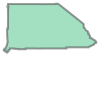

In [10]:
named_area_sb_county = usa.subgeographies.states['California'].counties['San_Bernardino_County']
display(named_area_sb_county)
named_area_sb_county.geometry.as_arcpy

In [11]:
sr_sb_county = named_area_sb_county.geometry["spatialReference"]
sr_sb_county

{'wkid': 4326, 'latestWkid': 4326}

In [12]:
named_area_la_county = usa.search(query='Los Angeles', layers=['US.Counties'])
named_area_la_county[0]

<NamedArea name:"Los Angeles County" area_id="06037", level="US.Counties", country="United States">

In [13]:
named_area_riverside_county = usa.search(query='Riverside', layers=['US.Counties'])
named_area_riverside_county[0]

<NamedArea name:"Riverside County" area_id="06065", level="US.Counties", country="United States">

## `arcgis.geometry.filters` module

Now all input data are ready, you are all set up to start creating spatial filters! The module `arcgis.geometry.filters` contains functions to filter query results by a spatial relationship with another geometry used when querying feature layers and imagery layers. You are going to see how `intersects()`, `contains`, etc. are being used to answer Jim's questions in the following sections:


### intersects

In order to find out what are the subsets of interstate highways that intersect with county of San Bernadino (or county of Los Angeles), we will use `arcgis.geometry.filters.intersects(geometry, sr=None)` to create a geometry filter that filters results whose geometry intersects with the specified geometry.

In [14]:
# construct a geometry filter using the filter geometry
sb_county_filter = intersects(named_area_sb_county.geometry, 
                              sr=sr_sb_county)

In [15]:
# query a feature layer for features that meet filter criteria
df_sb_county_Interstate = freeway_lyr.query(geometry_filter=sb_county_filter, 
                                            as_df=True)
df_sb_county_Interstate[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]]

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,4,I215,93.43523,150.36972
1,42,S66,14.10566,22.70091
2,47,S58,119.34584,192.06890
3,48,S60,66.98541,107.80279
4,139,I10,2367.17447,3809.60565
5,639,I40,2388.99433,3844.72138
6,672,I15,1410.53954,2270.04788
7,690,S210,40.46925,65.12908


In [16]:
df_sb_county_Interstate["ROUTE_NUM"].tolist()

['I215', 'S66', 'S58', 'S60', 'I10', 'I40', 'I15', 'S210']

As seen from the results shown above of applying an `intersects` filter at the `query`, there are 8 Interstate highways that go through (or say, intersect) the San Bernadino County, and they are namely the `I215, S66, S58, S60, I10, I40, I15, and S210`. If you are interested in finding out more information about any specified route of the resulting highways, e.g. the geometry/shape, you can run the subsequent two cells to create composite filtering criteria (with `where=` and `geometry_filter=`), get a finer query result, and parse the detailed properties.

In [17]:
# query a feature layer for features that meet filter criteria
sb_county_I15 = freeway_lyr.query(where="ROUTE_NUM = 'I15'",
                                  geometry_filter=sb_county_filter)
sb_county_I15

<FeatureSet> 1 features

{'OBJECTID': 672, 'ROUTE_NUM': 'I15', 'CLASS': 'I', 'NUMBER': '15', 'SUFFIX': ' ', 'DIST_MILES': 1410.53954, 'DIST_KM': 2270.04788}


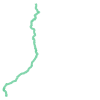

In [18]:
for feature in sb_county_I15.features:
    print(feature.attributes)   
    geom_dict = feature.geometry
    geom_dict["spatialReference"] = sr_sb_county
    freeway_obj = Polyline(geom_dict)
    display(freeway_obj.as_arcpy)

Similar to querying for highways intersecting the SB County, you can also make queries to highways that intersect with county of Los Angeles.

In [19]:
# construct a geometry filter using the filter geometry
la_county_filter = intersects(named_area_la_county[0].geometry, 
                              sr=sr_sb_county)

In [20]:
# query a feature layer for features that meet filter criteria
df_la_county_Interstate = freeway_lyr.query(geometry_filter=la_county_filter, 
                                            as_df=True)
display(df_la_county_Interstate.shape)
df_la_county_Interstate[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(24, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,2,I105,19.83041,31.91401
1,10,I605,27.13689,43.67268
2,11,I710,20.02547,32.22794
3,22,S10,0.63953,1.02922
4,24,S110,9.08802,14.62578


Query made upon the spatial filter that search results need to intersect with the geometry of LA County returns 24 entries in the resulting DataFrame, which means 24 Interstate highways go through (or say, intersect) the LA County, and you can see that `U101` is one of these 24 routes.

If interested in finding out more information about route `U101`, you can run the following two cells to create composite filtering criteria with `where` and `geometry_filter`, get a finer search result, and parse the detailed properties.

In [21]:
# query a feature layer for features that meet filter criteria
la_county_U101 = freeway_lyr.query(where="ROUTE_NUM = 'U101'",
                                   geometry_filter=la_county_filter)
la_county_U101

<FeatureSet> 1 features

{'OBJECTID': 675, 'ROUTE_NUM': 'U101', 'CLASS': 'U', 'NUMBER': '101', 'SUFFIX': ' ', 'DIST_MILES': 722.19665, 'DIST_KM': 1162.26517}


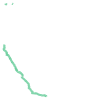

In [22]:
for feature in la_county_U101.features:
    print(feature.attributes)   
    geom_dict = feature.geometry
    geom_dict["spatialReference"] = sr_sb_county
    freeway_obj = Polyline(geom_dict)
    display(freeway_obj.as_arcpy)

## contains V.S. within

In the previous section, we have sorted out that 8 Interstate Highways, namely `I215, S66, S58, S60, I10, I40, I15, and S210`, intersect with county of San Bernadino, and 24 routes intersect with LA County. Now, let us find out which highways are entirely contained in these counties. You will need to use `arcgis.geometry.filters.contains(geometry, sr=None)` to compose the spatial filter that aims to return a feature if its shape is wholly contained within the search geometry (Valid for all shape type combinations).

On a side note, `arcgis.geometry.filters.within(geometry, sr=None)` is the opposite to `contains` in that it returns a feature if its shape wholly contains the search geometry (Valid for all shape type combinations).

In [23]:
# construct a geometry filter using the filter geometry
sb_county_filter2 = contains(named_area_sb_county.geometry, 
                             sr=sr_sb_county)

In [24]:
# query a feature layer for features that meet filter criteria
df_sb_county_Interstate2 = freeway_lyr.query(geometry_filter=sb_county_filter2, 
                                           as_df=True)
display(df_sb_county_Interstate2.shape)
df_sb_county_Interstate2[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(0, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM


As told by the cell output above, none of Interstate Highways is contained within the county boundaries of SB County. What about the county of Los Angeles?

In [25]:
# construct a geometry filter using the filter geometry
la_county_filter2 = contains(named_area_la_county[0].geometry, 
                             sr=sr_sb_county)

In [26]:
# query a feature layer for features that meet filter criteria
df_la_county_Interstate2 = freeway_lyr.query(geometry_filter=la_county_filter2, 
                                             as_df=True)
display(df_la_county_Interstate2.shape)
df_la_county_Interstate2[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(9, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,11,I710,20.02547,32.22794
1,22,S10,0.63953,1.02922
2,24,S110,9.08802,14.62578
3,29,S134,12.30291,19.79965
4,34,S170,6.02392,9.69458


In [27]:
num_contained = 0
for route_num in df_la_county_Interstate2["ROUTE_NUM"]:
    if route_num not in df_la_county_Interstate["ROUTE_NUM"]:
        num_contained+=1
print(num_contained, "out of 9 are contained in LA County, and not intersecting with County Boundaries")

9 out of 9 are contained in LA County, and not intersecting with County Boundaries


In [28]:
num_intersecting = 0
for route_num in df_la_county_Interstate["ROUTE_NUM"]:
    if route_num not in df_la_county_Interstate2["ROUTE_NUM"]:
        num_intersecting+=1
print(num_intersecting, "out of 24 are intersecting with County Boundaries, but not contained in LA County")

24 out of 24 are intersecting with County Boundaries, but not contained in LA County


As being validated from previous cell, there are 9 Interstate Highways that are contained in the county of Los Angeles, and none of those has intersection with the boundaries of the LA County.

### Crosses V.S. Overlaps

Though `crosses` and `overlaps` share some common grounds in their definitions:
  - `arcgis.geometry.filters.crosses(geometry, sr=None)` returns a feature if the intersection of the interiors of the two shapes is not empty and has a lower dimension than the maximum dimension of the two shapes. Two lines that share an endpoint in common do not cross. Valid for Line/Line, Line/Area, Multi-point/Area, and Multi-point/Line shape type combinations.
  - `arcgis.geometry.filters.overlaps(geometry, sr=None)` returns a feature if the intersection of the two shapes results in an object of the same dimension, but different from both of the shapes. Applies to Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations.

There is one major difference in that `overlaps` needs to be performed on two shapes with the same dimension (e.g. Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations), while `crosses` is between two shapes that their intersection has a lower dimension than the maximum dimension of them two.

In [29]:
# query a feature layer for features that meet filter criteria
df_sb_county_wildfire = wildfire_lyr.query(geometry_filter=sb_county_filter)
df_sb_county_wildfire

<FeatureSet> 9 features

With the `wildfire incides inside SB County` being returned from the query above, we can now loop within all point features of the wildfire incidents and create buffered area around the wildfire centers. Then with spatial filter `overlaps` composed, we can go onto query for `wilderness prevention areas` that overlap with the `wildfire buffered zones`.

In [32]:
fire_buffer_list = []
wild_areas_list = []

# loop within all point features of the wildfire incidents
for feature in df_sb_county_wildfire.features:
    dict_geom = feature.geometry
    dict_geom["spatialReference"] = sr_sb_county
    # create buffered area around the wildfire centers
    f_buffer = Point(dict_geom).buffer(0.05).generalize(0.01)
    fire_buffer_list.append(f_buffer)
    
    # creates a spatial filter
    f_buffer_filter = overlaps(f_buffer, sr=sr_sb_county)
    
    # query a feature layer for features that meet filter criteria;
    # result == wilderness prevention areas that overlap with the wildfire buffered zones
    f_buffer_wild_areas = wild_areas_lyr.query(geometry_filter=f_buffer_filter)
    df_f_buffer_wild_areas = f_buffer_wild_areas.sdf
    
    # print results and save
    if df_f_buffer_wild_areas.shape[0] > 0:
        display(df_f_buffer_wild_areas[["OBJECTID","NAME","Land_Type"]])
        wild_areas_list.append(f_buffer_wild_areas)

,OBJECTID,NAME,Land_Type
0,51,San Gorgonio Wilderness,Private Land


#### Visualizing the filtered results

Next, let us visualize the `wildfires`, the `buffered zone impacted by wildfires`, and the impacted `wilderness prevention areas` on a single MapView.


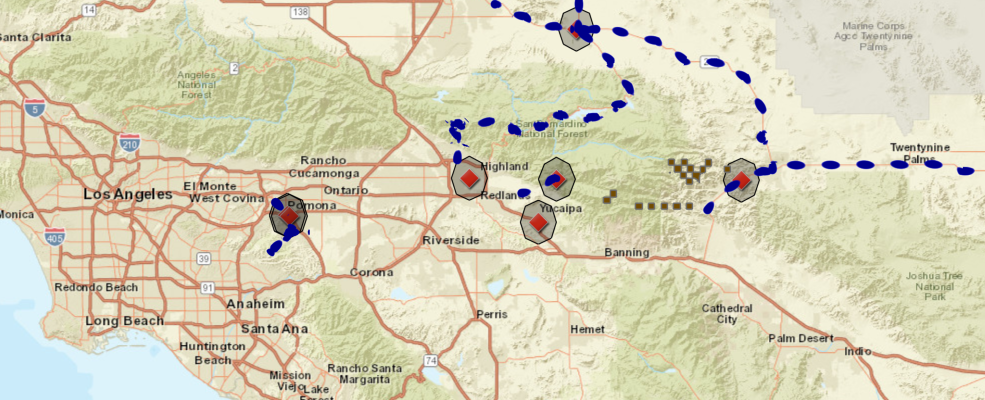

In [77]:
map1 = gis.map('Redlands, CA')
map1.basemap = 'streets'
map1

In [66]:
map1.draw(df_sb_county_wildfire,
          symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS",
                    "url":"http://static.arcgis.com/images/Symbols/Shapes/RedDiamondLargeB.png",
                    "contentType":"image/png","width":24,"height":24})

In [67]:
for f_b in fire_buffer_list:
    map1.draw(f_b)

In [68]:
for w_a in wild_areas_list:
    map1.draw(w_a,
              symbol = {
                          "type" : "esriSFS",
                          "style": "esriSFSSolid",
                          "color": [115,76,0,255],
                          "outline": {
                              "type": "esriSLS",
                              "style": "esriSLSSolid",
                              "color": [110,110,110,255],
                              "width": 1
                          }
                      })

#### Consider the impacted roads

In order to decide what secondary roads and local roads might get affected by the wildfire in SB County, we need to first create a FeatureLayer object from the transportation <a href="https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale">resources</a> provided by census bureau.

In [34]:
fl_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer"
secondary_roads_layer = FeatureLayer(fl_url+"/1")
local_roads_layer = FeatureLayer(fl_url+"/2")

We can use the class `PythonSwitch` defined below to explore all possible spatial relations within `arcgis.geometry.filters`, and discover the differences of each spatial filter:

In [40]:
# Implement Python Switch Case Statement using Class
class PythonSwitch:
    def switch(self, op):
        default = "Unsupported Operation"
        return getattr(self, 'case_' + str(op), lambda: default)()

    def case_1(self):
        return crosses(f_buffer, sr=sr_sb_county)
 
    def case_2(self):
        return contains(f_buffer, sr=sr_sb_county)
 
    def case_3(self):
        return intersects(f_buffer, sr=sr_sb_county)
    
    def case_4(self):
        return overlaps(f_buffer, sr=sr_sb_county)
 
    def case_5(self):
        return touches(f_buffer, sr=sr_sb_county)
 
    def case_6(self):
        return within(f_buffer, sr=sr_sb_county)
    
    def case_7(self):
        return envelope_intersects(f_buffer, sr=sr_sb_county)
 
    def case_8(self):
        return index_intersects(f_buffer, sr=sr_sb_county)

In [46]:
# For experimental purposes, just target at one of the fire buffered areas
for f_buffer in fire_buffer_list[1:2]:
    # switch case to loop thru all spatial relations
    for i in range(1,8):
        # creates a spatial filter
        s = PythonSwitch()
        f_buffer_filter = s.switch(i)
    
        # query a feature layer for features that meet filter criteria
        f_buffer_sec_roads = secondary_roads_layer.query(geometry_filter=f_buffer_filter)
        df_f_buffer_sec_roads = f_buffer_sec_roads.sdf

        # print results and save
        if df_f_buffer_sec_roads.shape[0] > 0:
            print("Op ", i, ":", df_f_buffer_sec_roads.shape[0])
            display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]])
        else:
            print("Op ", i, ": 0")

Op  1 : 5


,BASENAME,MTFCC,NAME,OBJECTID
0,Carbon Canyon,S1200,Carbon Canyon Rd,105274
1,142,S1200,State Rte 142,151298
2,142,S1200,State Rte 142,151385
3,Chino Hills,S1200,Chino Hills Pkwy,176259
4,Chino Hills,S1200,Chino Hills Pkwy,176276


Op  2 : 2


,BASENAME,MTFCC,NAME,OBJECTID
0,Corona,S1200,Corona Fwy,127560
1,Corona,S1200,Corona Fwy,127702


Op  3 : 9


,BASENAME,MTFCC,NAME,OBJECTID
0,Carbon Canyon,S1200,Carbon Canyon Rd,105274
1,Corona,S1200,Corona Fwy,127560
2,Corona,S1200,Corona Fwy,127702
3,142,S1200,State Rte 142,151298
4,142,S1200,State Rte 142,151385
5,Chino Hills,S1200,Chino Hills Pkwy,176259
6,Chino Hills,S1200,Chino Hills Pkwy,176276
7,142,S1200,State Rte 142,192667
8,71,S1200,State Rte 71,193841


Op  4 : 0
Op  5 : 0
Op  6 : 0
Op  7 : 9


,BASENAME,MTFCC,NAME,OBJECTID
0,Carbon Canyon,S1200,Carbon Canyon Rd,105274
1,Corona,S1200,Corona Fwy,127560
2,Corona,S1200,Corona Fwy,127702
3,142,S1200,State Rte 142,151298
4,142,S1200,State Rte 142,151385
5,Chino Hills,S1200,Chino Hills Pkwy,176259
6,Chino Hills,S1200,Chino Hills Pkwy,176276
7,142,S1200,State Rte 142,192667
8,71,S1200,State Rte 71,193841


After carefully observing the results, we can tell in this example, `intersects` works the same way as `envelope_intersects`, and `crosses` & `contains` each represent a mutually exclusive subset of what's derived from `intersects`.

In [47]:
impacted_sec_roads_list = []
impacted_loc_roads_list = []

for f_buffer in fire_buffer_list:
    # creates a spatial filter
    s = PythonSwitch()
    f_buffer_filter = s.switch(3)
    ##f_buffer_filter = intersects(f_buffer, sr=sr_sb_county)
    
    # query a feature layer for features that meet filter criteria
    f_buffer_sec_roads = secondary_roads_layer.query(geometry_filter=f_buffer_filter)
    df_f_buffer_sec_roads = f_buffer_sec_roads.sdf
    
    # print results and save
    if df_f_buffer_sec_roads.shape[0] > 0:
        # display(df_f_buffer_sec_roads.shape[0])
        # display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
        impacted_sec_roads_list.append(f_buffer_sec_roads)
        
    # query a feature layer for features that meet filter criteria
    f_buffer_loc_roads = local_roads_layer.query(geometry_filter=f_buffer_filter)
    df_f_buffer_loc_roads = f_buffer_loc_roads.sdf
    
    # print results and save
    if df_f_buffer_loc_roads.shape[0] > 0:
        # display(df_f_buffer_loc_roads.shape[0])
        # display(df_f_buffer_loc_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
        impacted_loc_roads_list.append(f_buffer_loc_roads)

Now that we have obtained `impacted_sec_roads_list` and `impacted_loc_roads_list` that store the secondary and local roads impacted by the wildfire, it is straight forward to just map them in the Map Widget as well.

In [72]:
for road in impacted_sec_roads_list:
    map1.draw(road,
              symbol = {
                          "type": "simple-line",
                          "color": "darkblue",
                          "width": "8px",
                          "style": "short-dot"
                        })

In [64]:
for road in impacted_loc_roads_list:
    map1.draw(road,
              symbol = {
                          "type": "simple-line",
                          "color": "lightblue",
                          "width": "4px",
                          "style": "short-dot"
                        })

## Conclusions

In this part 3 of the guide series to geometry module, you have seen demonstrations of how to apply spatial filtering with spatial filter objects created within `arcgis.geometry.filters` in order to filter query results by a spatial relationship with another geometry used when querying feature layers and imagery layers.

The choice to make between various spatial relations for spatial queries depends on what is known prior to executing the query and the type of results needed. If the goal of the query is to find features that satisfy a spatial relationship with a single geometry (or a collection of geometries), use a spatial filter. 
 
What's not mentioned here but still important for improving efficiencies and precisons of queries, is that users should consider `spatial caching` and `tolerance` when executing spatial queries. If multiple spatial queries are going to be executed within a common extent, the use of spatial caching can significantly increase performance by reducing round trips to the data source. A feature class x,y tolerance can have an effect on the results of a spatial query and should be considered when executing spatial queries, particularly with feature classes that have unusually large x,y tolerances. For more information, please check out <a href="http://resources.esri.com/help/9.3/arcgisengine/dotnet/7b4b8987-a3f0-4954-980f-720e61965449.htm">Resouces on ArcGIS engine</a>.